# Identify high-z QSOs in photmetirc datasets

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import astropy
from astropy.io import fits
from astropy.table import Table
from collections import Counter

In [2]:
os.chdir('/data/VOSS23')

## Load data (big table)

In [3]:
bigtable = []
for filename in os.listdir('.'):
    if 'VOSS23_BigTable' in filename:
        print('Reading', filename)
        hdul = astropy.io.fits.open(filename)
        data = astropy.table.Table.read(hdul[1])
        data.meta.clear()  # Avoid warnings when merging meta
        bigtable.append(data)
bigtable = astropy.table.vstack(bigtable)
bigtable['objtype'] = np.char.strip(bigtable['objtype']) #strip blanks

Reading VOSS23_BigTable1.fits.gz
Reading VOSS23_BigTable2.fits.gz
Reading VOSS23_BigTable3.fits.gz
Reading VOSS23_BigTable4.fits.gz
Reading VOSS23_BigTable5.fits.gz
Reading VOSS23_BigTable6.fits.gz
Reading VOSS23_BigTable7.fits.gz
Reading VOSS23_BigTable8.fits.gz


### Know your data!

In [4]:
bigtable

qid,RAd,DECd,objtype,z_spec,gaia_id,pmra,pmdec,pm,pmra_error,pmdec_error,parallax_over_error,phot_bp_mean_mag,phot_rp_mean_mag,phot_g_mean_mag,wise_id,w1mpro,w2mpro,w3mpro,w4mpro,pans_id,gPSFMag,rPSFMag,iPSFMag,zPSFMag,yPSFMag
int64[1],float64[1],float64[1],str8,float32[1],int64[1],float64[1],float64[1],float32[1],float32[1],float32[1],float32[1],float32[1],float32[1],float32[1],int64[1],float32[1],float32[1],float32[1],float32[1],int64[1],float64[1],float64[1],float64[1],float64[1],float64[1]
20980005,309.6284631561126,-25.43884947678723,Star,--,14074140,2.0603751134756254,-2.1256130838115306,2.9603,0.0718607,0.0624142,11.7142,17.7311,16.3309,17.0846,735856251,14.696,14.762,12.441,8.846,18675517,17.95789909362793,17.05500030517578,16.699600219726562,16.609800338745117,16.336999893188477
28443138,358.8349544348019,-21.10044037697573,Star,--,23419137,29.682608262496313,-16.45055637558464,33.9364,0.159776,0.12759,10.643,19.0752,17.027,18.0174,249299010,14.804,14.763,12.573,9.046,26259440,19.35260009765625,18.17840003967285,17.40130043029785,17.035900115966797,16.863100051879883
6971647,170.51112225797812,-18.808950719447544,Star,--,7787223,-16.449670393171726,0.4281318081068334,16.4552,0.0440459,0.0330324,12.0587,16.3822,15.5985,16.0783,366699122,14.608,14.671,12.303,8.861,4365788,16.61590003967285,16.042200088500977,15.890199661254883,15.818499565124512,15.8125
30839426,59.0739288,10.7331647,Star,--,117500651,0.38058238231466385,-3.69963547259921,3.71916,0.0690588,0.049467,3.81315,17.0005,15.9675,16.5673,340034728,14.64,14.618,12.504,8.588,28747168,17.037200927734375,16.527299880981445,16.354700088500977,16.179000854492188,16.180099487304688
3417102,138.71368000524,-8.49101800127327,Star,--,29802627,-2.6235620222280334,-4.683156863216182,5.36796,0.155761,0.129209,1.80698,19.1639,17.7185,18.479,611163634,15.867,16.142,12.329,9.009,722215,19.235000610351562,18.46929931640625,18.05699920654297,17.9064998626709,17.827899932861328
6457883,166.31444310060354,-9.613649394213933,Star,--,12802919,-8.985552231757383,-2.754729146408433,9.39833,0.0806062,0.067881,2.92693,17.229,16.4216,16.9181,385485715,15.454,15.354,12.609,8.859,3836957,17.273000717163086,16.868099212646484,16.816200256347656,16.71929931640625,16.67799949645996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33375598,71.43007042,2.54713923,,--,127393176,--,--,--,--,--,--,18.1715,16.4645,20.001,0,--,--,--,--,31354752,18.646699905395508,17.752599716186523,17.20989990234375,16.88920021057129,16.702299118041992
33375600,72.53192628,2.54132884,Star,--,123612751,1.7653624762972873,0.35850922343317226,1.8014,0.335337,0.264918,-0.101078,19.8911,18.5198,19.1958,0,--,--,--,--,31354754,20.086200714111328,19.222999572753906,18.821500778198242,18.63129997253418,18.478700637817383


In [5]:
Counter(bigtable['objtype'])

Counter({'Star': 5960751,
         '': 1678433,
         'Galaxy': 150581,
         'other': 2172,
         'QSOlowZ': 16274,
         'QSOhighZ': 1903})

In [6]:
print("%-20s | %-10s | %10s | %10s | %10s | %6s" % ('Column', 'Type', 'Min', 'Max', 'Mean', '%NaN'))
for col in bigtable.colnames:
    vv = bigtable[col].value
    if col == 'objtype':
        print('%-20s | %-10s | skipped' % (col, vv.dtype))
        continue
    print("%-20s | %-10s | %10.4g | %10.4g | %10.4g | %6.2f" % (col, vv.dtype,
                                              np.min(vv), np.max(vv), np.mean(vv),
                                              np.count_nonzero(np.isnan(vv)) / len(bigtable) * 100))
print('Number of rows:', len(bigtable))

Column               | Type       |        Min |        Max |       Mean |   %NaN
qid                  | int64      |       9369 |  3.338e+07 |  1.744e+07 |   0.00
RAd                  | float64    |   1.31e-05 |        360 |      198.1 |   0.00
DECd                 | float64    |     -30.96 |         15 |     -7.787 |   0.00
objtype              | <U8        | skipped
z_spec               | float32    |    -0.0016 |       5.17 |      0.627 |  99.50
gaia_id              | int64      |          0 |   1.35e+08 |  6.762e+07 |   0.00
pmra                 | float64    |     -342.9 |      369.4 |     -1.659 |  20.32
pmdec                | float64    |       -330 |      463.9 |     -4.856 |  20.32
pm                   | float32    |   0.001329 |      463.9 |      11.02 |  20.32
pmra_error           | float32    |   0.006285 |       3.21 |     0.2579 |  20.32
pmdec_error          | float32    |   0.006314 |      3.132 |     0.2143 |  20.32
parallax_over_error  | float32    |      -22.2 |      

## Prepare features and labels

In [7]:
# Index of known and unclassified rows
iknown        = np.where(bigtable['objtype'] != '')[0]
iunclassified = np.where(bigtable['objtype'] == '')[0]

# Numerical features
features = np.hstack((bigtable['phot_bp_mean_mag'].value,
                      bigtable['phot_rp_mean_mag'].value,
                      bigtable['phot_g_mean_mag'].value,
                      bigtable['wise_id'].value,
                      bigtable['w1mpro'].value,
                      bigtable['w2mpro'].value,
                      bigtable['w3mpro'].value,
                      bigtable['w4mpro'].value,
                      bigtable['pans_id'].value,
                      bigtable['gPSFMag'].value,
                      bigtable['rPSFMag'].value,
                      bigtable['iPSFMag'].value,
                      bigtable['zPSFMag'].value,
                      bigtable['yPSFMag'].value))

# Label <-> number mapping. Note: XGBoost requires labels in the range [0, num_class)
label2num_map = {'QSOhighZ': 0, 'QSOlowZ': 1, 'Star': 2, 'Galaxy': 3, 'other': 4}
num2label_map = dict(zip(label2num_map.values(), label2num_map.keys()))

# Labels in the "known" dataset
nlabels = np.asarray([label2num_map[l] for l in bigtable['objtype'][iknown]])

## Classification with XGBoost

In [8]:
# from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score
import xgboost as xgb
print(xgb.__version__)

1.7.6


### Train / test split

In [9]:
features_train, features_test, nlabels_train, nlabels_test = train_test_split(features[iknown], nlabels, 
                                                                              test_size=0.2, random_state=1, stratify=nlabels)

Is the train / test split stratified?

In [10]:
print('Train test size: ', len(nlabels_train), len(nlabels_train) / len(iknown))
print('Test  test size: ', len(nlabels_test) , len(nlabels_test)   / len(iknown))
print("%-15s | %-10s | %6s | %10s | %6s" % ('Label', 'N_train', '%train', 'N_test', '%test'))
for nlabel in label2num_map.values():
    Ntrain = np.count_nonzero(nlabels_train == nlabel)
    Ntest  = np.count_nonzero(nlabels_test  == nlabel)
    print("%-15s | %10d | %6.3g | %10d | %6.3f" % (num2label_map[nlabel] + ' (' + str(nlabel) + ')',
                                                   Ntrain, 100 * Ntrain / len(nlabels_train),
                                                   Ntest , 100 * Ntest  / len(nlabels_test),))
print('Unclassified:    ', len(iunclassified))

Train test size:  4905344 0.7999998695300685
Test  test size:  1226337 0.20000013046993148
Label           | N_train    | %train |     N_test |  %test
QSOhighZ (0)    |       1522 |  0.031 |        381 |  0.031
QSOlowZ (1)     |      13019 |  0.265 |       3255 |  0.265
Star (2)        |    4768600 |   97.2 |    1192151 | 97.212
Galaxy (3)      |     120465 |   2.46 |      30116 |  2.456
other (4)       |       1738 | 0.0354 |        434 |  0.035
Unclassified:     1678433


### Set hyper-parameters

In [12]:
param = {
    'max_depth': 10,  
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss',
    'num_class': len(label2num_map) }   # <-- note here!
steps = 10  # The number of training iterations

### Train model

In [13]:
D_train = xgb.DMatrix(features_train, label=nlabels_train)
D_test  = xgb.DMatrix(features_test , label=nlabels_test)

watchlist = [(D_train, 'Train'), (D_test,'Test')]
evals_result = {}
model = xgb.train(param, D_train, steps, watchlist, evals_result=evals_result)

/home/gcalderone/.local/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	Train-mlogloss:0.94842	Test-mlogloss:0.94859
[1]	Train-mlogloss:0.64624	Test-mlogloss:0.64656
[2]	Train-mlogloss:0.45867	Test-mlogloss:0.45912
[3]	Train-mlogloss:0.33255	Test-mlogloss:0.33314
[4]	Train-mlogloss:0.24460	Test-mlogloss:0.24529
[5]	Train-mlogloss:0.18193	Test-mlogloss:0.18272
[6]	Train-mlogloss:0.13667	Test-mlogloss:0.13758
[7]	Train-mlogloss:0.10377	Test-mlogloss:0.10479
[8]	Train-mlogloss:0.07967	Test-mlogloss:0.08082
[9]	Train-mlogloss:0.06192	Test-mlogloss:0.06320


Check for over/under-fitting

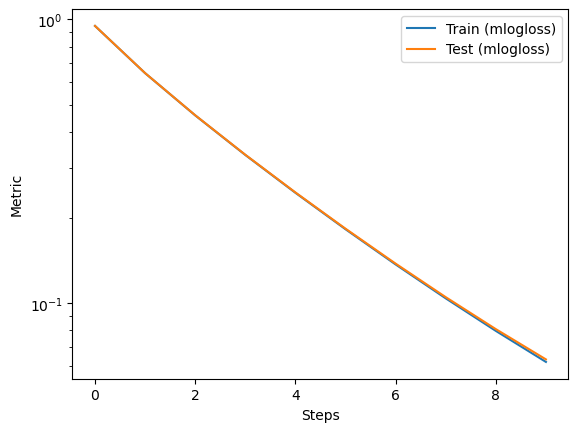

In [14]:
for dataset in evals_result.keys():
    for metric in evals_result[dataset].keys():
        plt.plot(evals_result[dataset][metric], label=dataset + ' (' + metric + ')')
plt.xlabel('Steps')
plt.ylabel('Metric')
plt.yscale("log")
plt.legend()
plt.show()

### Predict on test set and evaluate metrics

In [26]:
preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])
print("Precision = {}".format(precision_score(nlabels_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(nlabels_test, best_preds, average='macro')))

Precision = 0.8161054934152462
Recall = 0.6443070772606541


Are the above metrics acutally meaningful, or expected, in our case?

In [18]:
P = dict()
pP = dict()
print("%10s | " % "", end='')
for pred_nlabel in label2num_map.values():
    print("%10s | " % num2label_map[pred_nlabel], end='')
print("%10s |" % "Total")
for true_nlabel in label2num_map.values():
    print("%-10s | " % num2label_map[true_nlabel], end='')
    for pred_nlabel in label2num_map.values():
        nn = np.count_nonzero((nlabels_test == true_nlabel)  &  (best_preds == pred_nlabel))
        print("%10d | " % nn, end='')
    nn = np.count_nonzero(nlabels_test == true_nlabel)
    P[true_nlabel] = nn
    print("%10d | " % nn)
print("%-10s | " % "Total", end='')
for pred_nlabel in label2num_map.values():
    nn = np.count_nonzero(best_preds == pred_nlabel)
    pP[pred_nlabel] = nn
    print("%10d | " % nn, end='')
print()
print()

for norm in [pP, P]:
    print("%10s | " % "", end='')
    for pred_nlabel in label2num_map.values():
        print("%10s | " % num2label_map[pred_nlabel], end='')
    print()
    for true_nlabel in label2num_map.values():
        print("%-10s | " % num2label_map[true_nlabel], end='')
        for pred_nlabel in label2num_map.values():
            nn = np.count_nonzero((nlabels_test == true_nlabel)  &  (best_preds == pred_nlabel))
            print("%10.2f | " % (100 * nn / norm[pred_nlabel]), end='')
        print()
    print()

           |   QSOhighZ |    QSOlowZ |       Star |     Galaxy |      other |      Total |
QSOhighZ   |        194 |        136 |         48 |          3 |          0 |        381 | 
QSOlowZ    |         64 |       2617 |        110 |        464 |          0 |       3255 | 
Star       |         11 |         64 |    1191830 |        246 |          0 |    1192151 | 
Galaxy     |          3 |        148 |       3149 |      26809 |          7 |      30116 | 
other      |          0 |         21 |         10 |        395 |          8 |        434 | 
Total      |        272 |       2986 |    1195147 |      27917 |         15 | 

           |   QSOhighZ |    QSOlowZ |       Star |     Galaxy |      other | 
QSOhighZ   |      71.32 |       4.55 |       0.00 |       0.01 |       0.00 | 
QSOlowZ    |      23.53 |      87.64 |       0.01 |       1.66 |       0.00 | 
Star       |       4.04 |       2.14 |      99.72 |       0.88 |       0.00 | 
Galaxy     |       1.10 |       4.96 |       0.26 |  

In [23]:
print("Precision = {}".format(precision_score(nlabels_test, best_preds, average=None)))
print("Recall = {}".format(recall_score(nlabels_test, best_preds, average=None)))

Precision = [0.71323529 0.87642331 0.99722461 0.96031092 0.53333333]
Recall = [0.50918635 0.80399386 0.99973074 0.89019126 0.01843318]
